In [30]:
import cv2
import numpy as np

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier


# Problem 1 kmeans

ref: https://medium.com/@a4793706/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-k-means-clustering-in-python-%E9%99%84%E7%A8%8B%E5%BC%8F%E7%A2%BC%E4%BB%8B%E7%B4%B9-55c19bcf2280

## 1.1 K = 2, 4, 8, 16, and 32,

In [57]:
img = cv2.imread("bird.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.resize(img, (64,64))

def cluster(img, n_cluster=4):
    (h,w,c) = img.shape
    arr = img.reshape((w*h,c))

    kmeans = KMeans(n_clusters=n_cluster)
    kmeans.fit(arr)

    labels = kmeans.predict(arr)
    labels = labels.reshape((h,w))
    centers = kmeans.cluster_centers_.astype(np.uint8)
    
    out_img = np.zeros((h,w,3)).astype(np.uint8)
    for i in range(h):
        for j in range(w):
            out_img[i][j] = centers[labels[i][j]][:3]
            
    return out_img, centers


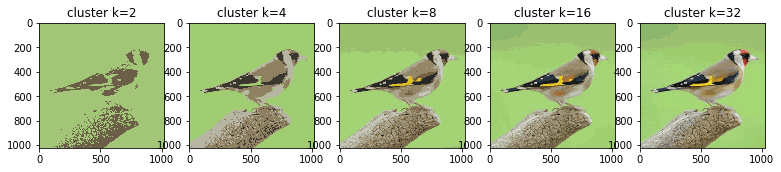

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

k_candidates = [2,4,8,16,32]

fig = plt.figure(figsize=(13,5))
for i,k in enumerate(k_candidates):
    out_img, centers = cluster(img,k)
    
    plt.subplot(1, len(k_candidates), i+1)
    plt.title(f"cluster k={k}")
    plt.imshow(out_img)
    
plt.show()
    

## 1.2 add x,y channel

In [33]:
def add_xy_ch(img):
    (w,h,c) = img.shape
    ch_x = np.array([[[i] for i in range(w)] for j in range(h)])
    ch_y = np.array([[[j] for i in range(w)] for j in range(h)])
    return np.concatenate((img, ch_x, ch_y), axis=2)

img_xy = add_xy_ch(img)

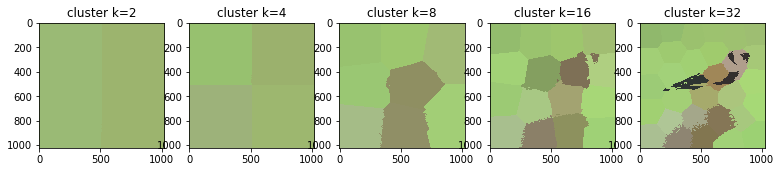

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

k_candidates = [2,4,8,16,32]

fig = plt.figure(figsize=(13,5))
for i,k in enumerate(k_candidates):
    out_img, centers = cluster(img_xy,k)
    
    plt.subplot(1, len(k_candidates), i+1)
    plt.title(f"cluster k={k}")
    plt.imshow(out_img, cmap='gray')
    
plt.show()
    

## 1.3


加入了x,y的postion當作cluster的information，可以看得出來segment的結果，看起來邊界越來越smooth了，而且cluster後的結果會考慮到spatial
的關西，會在附近的東西比較會是同一個object，因此可見加入x,y的information效果比較好。

In [76]:
def add_xy_ch(img):
    (w,h,c) = img.shape
    ch_x = np.array([[[i/10] for i in range(w)] for j in range(h)])
    ch_y = np.array([[[j/30] for i in range(w)] for j in range(h)])
    return np.concatenate((img, ch_x, ch_y), axis=2)

img_xy = add_xy_ch(img)

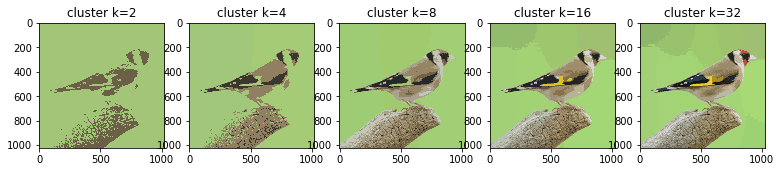

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

k_candidates = [2,4,8,16,32]

fig = plt.figure(figsize=(13,5))
for i,k in enumerate(k_candidates):
    out_img, centers = cluster(img_xy,k)
    
    plt.subplot(1, len(k_candidates), i+1)
    plt.title(f"cluster k={k}")
    plt.imshow(out_img, cmap='gray')
    
plt.show()
    

---
---
---

# Problem 2 PCA

In [6]:
DATA_PATH = "p2_data/"

train_faces, test_faces = [], []
for people in range(1,41):
    for i in range(1,10):
        face = cv2.imread(f"{DATA_PATH}/{people}_{i}.png",  cv2.IMREAD_GRAYSCALE)
        train_faces.append(face)
    face = cv2.imread(f"{DATA_PATH}/{people}_10.png",  cv2.IMREAD_GRAYSCALE)
    test_faces.append(face)
    
train_faces = np.array(train_faces).astype(np.uint8)
test_faces = np.array(test_faces).astype(np.uint8)

## 2.1

In [7]:
mean_face = np.mean(train_faces, axis=(0))

(train_num, h, w) = train_faces.shape
X = (train_faces-mean_face).reshape((train_num,h*w)).T

In [8]:
from numpy.linalg import svd

U, Sigma, V_t = svd(X, full_matrices=True)

eign_vectors, eign_values = U.T, Sigma

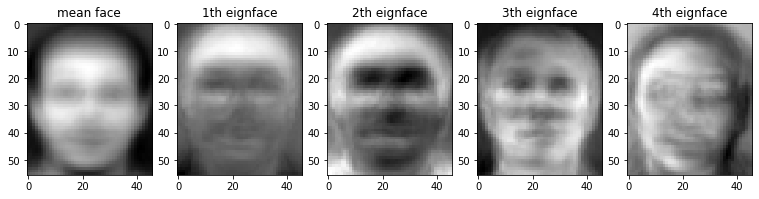

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

candidates = [0,1,2,3]

fig = plt.figure(figsize=(13,5))
plt.subplot(1, len(candidates)+1, 1)
plt.title("mean face")
plt.imshow(mean_face.reshape(56,46), cmap='gray')
for i in candidates:    
    plt.subplot(1, len(candidates)+1, i+2)
    plt.title(f"{i+1}th eignface")
    plt.imshow(eign_vectors[i].reshape(56,46), cmap='gray')
    
plt.show()

## 2.2

In [10]:
def face2vec(face):
    if len(face.shape)==2:
        face = (face - mean_face).flatten()
    else:
        face = face - mean_face.flatten()
    vec = np.dot(eign_vectors,face)
    return vec

def reconstruct(vec, n):
    face = np.matmul(vec[:n],eign_vectors[:n])
    face = face + mean_face.flatten()
    return face

def mse(img1,img2):
    img1,img2 = img1.flatten(),img2.flatten()
    return "{:.3f}".format(np.nanmean((img1-img2)**2))



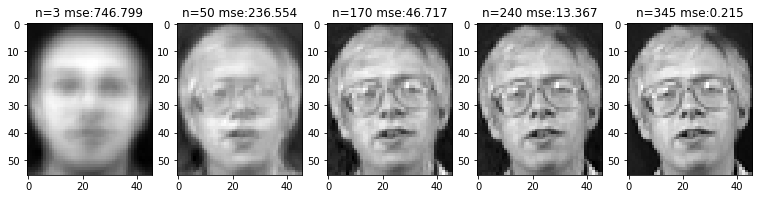

In [11]:

face = cv2.imread(f"{DATA_PATH}/2_1.png", cv2.IMREAD_GRAYSCALE)
vec = face2vec(face)

n_candidates = [3, 50, 170, 240, 345]

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(13,5))
for i,n in enumerate(n_candidates):
    reconst_face = reconstruct(vec, n)
    
    plt.subplot(1, len(k_candidates), i+1)
    plt.title(f"n={n} mse:{mse(face,reconst_face)}")
    plt.imshow(reconst_face.reshape(56,46), cmap='gray')
    
plt.show()


## 2.3

In [12]:

n_candidates = [3, 50, 170, 240, 345]

for i,n in enumerate(n_candidates):
    reconst_face = reconstruct(vec, n)
    print(f"n={n} mse:{mse(face,reconst_face)}")


n=3 mse:746.799
n=50 mse:236.554
n=170 mse:46.717
n=240 mse:13.367
n=345 mse:0.215


## 2.4

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_candidates = [1, 3, 5]
n_candidates = [3, 50, 170]

X = np.array([face2vec(face) for face in train_faces])
Y = np.array([i for i in range(40) for j in range(9)])

for k in k_candidates:
    for n in n_candidates:
        knn = KNeighborsClassifier(n_neighbors=k)
        
        cv_scores = cross_val_score(knn, X[:,:n], Y, cv=3)
        
        print(f" knn k:{k}, vec dim n:{n}, cv score:{'{:.3f}'.format(cv_scores.mean())}")
        

 knn k:1, vec dim n:3, cv score:0.650
 knn k:1, vec dim n:50, cv score:0.961
 knn k:1, vec dim n:170, cv score:0.956
 knn k:3, vec dim n:3, cv score:0.611
 knn k:3, vec dim n:50, cv score:0.900
 knn k:3, vec dim n:170, cv score:0.889
 knn k:5, vec dim n:3, cv score:0.561
 knn k:5, vec dim n:50, cv score:0.847
 knn k:5, vec dim n:170, cv score:0.822


## 2.5

In [14]:
best_k = 1
best_n = 50

X = np.array([face2vec(face) for face in train_faces])
Y = np.array([i for i in range(40) for j in range(9)])

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X[:,:best_n], Y)

X_test = np.array([face2vec(face) for face in test_faces])
Y_test = np.array([i for i in range(40) for j in range(1)])
Y_pred = knn.predict(X_test[:,:best_n])

acc = (Y_test==Y_pred).sum()/len(Y_test)
print(f" recognition rate of the testing set: {acc}")

 recognition rate of the testing set: 0.925


# Problem 3 Filter

## 3.1 

In [94]:
sigma = 1/(2 * ((2*np.log(2)) ** 2))

filter_ = [[i**2+j**2 for j in range(-1,2)] for i in range(-1,2)]
filter_ = np.exp(-np.array(filter_)/sigma) / (np.pi*sigma)
filter_

array([[5.61127499e-04, 2.62015084e-02, 5.61127499e-04],
       [2.62015084e-02, 1.22346355e+00, 2.62015084e-02],
       [5.61127499e-04, 2.62015084e-02, 5.61127499e-04]])

In [95]:
img = cv2.imread("lena.png", cv2.IMREAD_GRAYSCALE)
def gauss_filter(img):
    img_pad = np.pad(img, ((1,1),(1,1)), 'constant', constant_values=((0,0),(0,0)))
    (h,w) = img_pad.shape

    sigma = 1/(2 * ((2*np.log(2)) ** 2))

    filter_ = [[i**2+j**2 for j in range(-1,2)] for i in range(-1,2)]
    filter_ = np.exp(-np.array(filter_)/sigma) / (np.pi*sigma)

    output = np.zeros((h,w))

    for i in range(1,h-1):
        for j in range(1,w-1):
            output[i][j] = np.dot(img_pad[i-1:i+2,j-1:j+2].flatten(), filter_.flatten())

    return output[1:h-1,1:w-1]
    
output = gauss_filter(img)

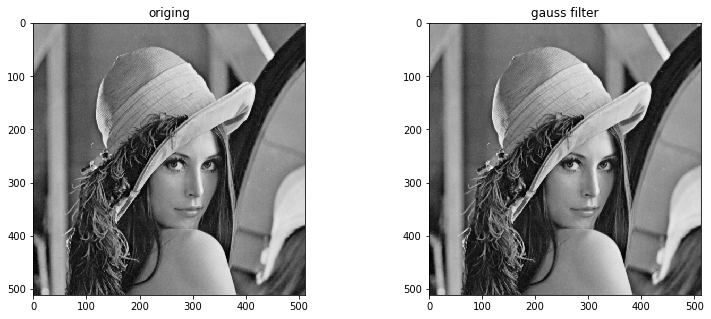

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.title('origing')
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.title('gauss filter')
plt.imshow(output, cmap='gray')
plt.show()

## 3.2

In [97]:
img = cv2.imread("lena.png", cv2.IMREAD_GRAYSCALE)

## x gradient
def comput_x_grad(img):
    img_pad = np.pad(img, ((1,1),(0,0)), 'constant', constant_values=((0,0),(0,0)))
    (h,w) = img_pad.shape

    filter_x = np.array([[1],[0],[-1]])*0.5

    output_x_grad = np.zeros((h,w))

    for i in range(1,h-1):
        for j in range(0,w):
            output_x_grad[i][j] = np.dot(img_pad[i-1:i+2,j].flatten(), filter_x.flatten())

    return output_x_grad[1:h-1,:]

output_x_grad = comput_x_grad(img)

## y gradient
def comput_y_grad(img):
    img_pad = np.pad(img, ((0,0),(1,1)), 'constant', constant_values=((0,0),(0,0)))
    (h,w) = img_pad.shape

    filter_y = np.array([1,0,-1])*0.5
    
    output_y_grad = np.zeros((h,w))

    for i in range(0,h):
        for j in range(1,w-1):
            output_y_grad[i][j] = np.dot(img_pad[i,j-1:j+2].flatten(), filter_y.flatten())

    return output_y_grad[:,1:w-1]

output_y_grad = comput_y_grad(img)


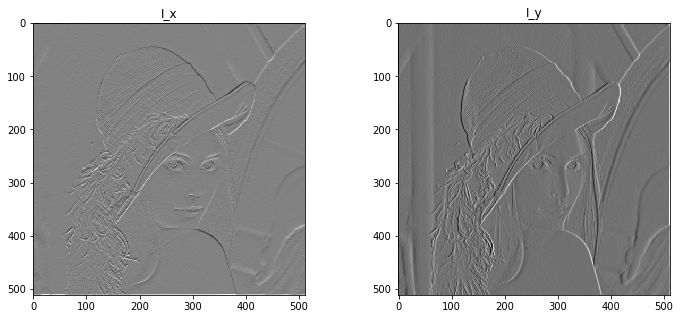

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("I_x")
plt.imshow(output_x_grad, cmap='gray')
plt.subplot(1,2,2)
plt.title("I_y")
plt.imshow(output_y_grad, cmap='gray')
plt.show()

## 3.3

In [102]:
def comput_gradient_mag(img):
    x_grad = comput_x_grad(img)
    y_grad = comput_y_grad(img)
    total_grad = np.sqrt(x_grad**2+y_grad**2)
    return total_grad
    
grad_origin = comput_gradient_mag(img)
grad_gauss = comput_gradient_mag(gauss_filter(img))

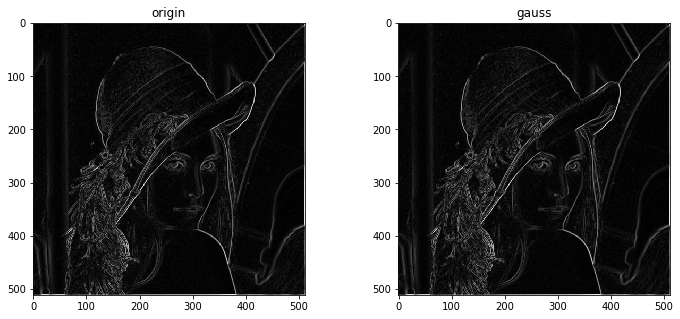

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('origin')
plt.imshow(grad_origin, cmap='gray')
plt.subplot(1,2,2)
plt.title('gauss')
plt.imshow(grad_gauss, cmap='gray')
plt.show()

In [104]:
grad_origin.mean(), grad_gauss.mean()

(7.276406752791582, 9.419025712487326)